In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import xlrd
from sklearn import linear_model
from sklearn import preprocessing
import statsmodels.formula.api as smf
import scipy.stats as stats
from sklearn import preprocessing


In [2]:
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

plt.rcParams['figure.figsize'] = [20.0, 7.0]
plt.rcParams.update({'font.size': 22})

sns.set_palette('bright')
sns.set_style('whitegrid')
sns.set_context('talk')

In [3]:
df = pd.read_excel('table_8_offenses_known_to_law_enforcement_new_york_by_city_2013.xls', header=4, skipfooter=3)
test_df = pd.read_excel('table-8-pennsylvania.xls', header=4, skipfooter=4)

In [4]:
print(df.shape)

## sample returns random sample of rows!
df.sample(10)

(348, 13)


,City,Population,Violent crime,Murder and nonnegligent manslaughter,Rape (revised definition)1,Rape (legacy definition)2,Robbery,Aggravated assault,Property crime,Burglary,Larceny- theft,Motor vehicle theft,Arson3
272,Rochester,210562,2107,42,nan,92,918,1055,10051,2587,6855,609,132.000
55,Chittenango Village,5016,1,0,nan,0,0,1,65,11,53,1,nan
80,Dryden Village,1913,3,0,nan,0,1,2,99,6,93,0,nan
140,Hempstead Village,55198,433,10,nan,3,204,216,958,206,630,122,2.000
70,Cuba Town,3209,5,0,nan,1,0,4,81,7,72,2,0.000
204,Mount Morris Village,2912,2,0,nan,0,1,1,74,10,63,1,nan
183,Malverne Village,8542,4,0,nan,0,3,1,21,3,17,1,0.000
205,Mount Pleasant Town,26564,12,0,nan,0,6,6,226,25,198,3,0.000
99,Fallsburg Town,12109,22,1,nan,0,0,21,162,65,96,1,nan
117,Glen Cove,27134,3,0,nan,0,1,2,62,5,54,3,0.000


In [5]:
df.columns

Index(['City', 'Population', 'Violent\ncrime',
       'Murder and\nnonnegligent\nmanslaughter',
       'Rape\n(revised\ndefinition)1', 'Rape\n(legacy\ndefinition)2',
       'Robbery', 'Aggravated\nassault', 'Property\ncrime', 'Burglary',
       'Larceny-\ntheft', 'Motor\nvehicle\ntheft', 'Arson3'],
      dtype='object')

In [6]:
test_df.columns

Index(['City', 'Population', 'Violent\ncrime',
       'Murder and\nnonnegligent\nmanslaughter',
       'Rape\n(revised\ndefinition)1', 'Rape\n(legacy\ndefinition)2',
       'Robbery', 'Aggravated\nassault', 'Property\ncrime', 'Burglary',
       'Larceny-\ntheft', 'Motor\nvehicle\ntheft', 'Arson3'],
      dtype='object')

In [7]:
#fixing column names
df = df.rename(columns={'Violent\ncrime':'Violent_Crime',
           'Murder and\nnonnegligent\nmanslaughter':'Murder',
           'Rape\n(revised\ndefinition)1':'Rape_Revised',
           'Rape\n(legacy\ndefinition)2':'Rape_Legacy',
           'Aggravated\nassault':'Agg_Assault',
           'Property\ncrime':'Property_Crime',
           'Larceny-\ntheft':'Larceny',
           'Motor\nvehicle\ntheft':'Motor_Vehicle_Theft',
           'Arson3':'Arson'             
          })

test_df = test_df.rename(columns={'Violent\ncrime':'Violent_Crime',
           'Murder and\nnonnegligent\nmanslaughter':'Murder',
           'Rape\n(revised\ndefinition)1':'Rape_Revised',
           'Rape\n(legacy\ndefinition)2':'Rape_Legacy',
           'Aggravated\nassault':'Agg_Assault',
           'Property\ncrime':'Property_Crime',
           'Larceny-\ntheft':'Larceny',
           'Motor\nvehicle\ntheft':'Motor_Vehicle_Theft',
           'Arson3':'Arson'             
          })

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 348 entries, 0 to 347
Data columns (total 13 columns):
City                   348 non-null object
Population             348 non-null int64
Violent_Crime          348 non-null int64
Murder                 348 non-null int64
Rape_Revised           0 non-null float64
Rape_Legacy            348 non-null int64
Robbery                348 non-null int64
Agg_Assault            348 non-null int64
Property_Crime         348 non-null int64
Burglary               348 non-null int64
Larceny                348 non-null int64
Motor_Vehicle_Theft    348 non-null int64
Arson                  187 non-null float64
dtypes: float64(2), int64(10), object(1)
memory usage: 35.4+ KB


In [9]:
# from https://github.com/WillKoehrsen/machine-learning-project-walkthrough/blob/master/Machine%20Learning%20Project%20Part%201.ipynb
# Function to calculate missing values by column# Funct 
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns
missing_values_table(df)

Your selected dataframe has 13 columns.
There are 2 columns that have missing values.


,Missing Values,% of Total Values
Rape_Revised,348,100.000
Arson,161,46.300


In [10]:
#checking missing values for test_df
missing_values_table(test_df)

Your selected dataframe has 13 columns.
There are 2 columns that have missing values.


,Missing Values,% of Total Values
Rape_Legacy,853,100.000
Arson,1,0.100


In [11]:
#100% of Rape_Revised column is null so dropping column
df=df.drop('Rape_Revised', 1)
test_df=test_df.drop('Rape_Legacy', 1)

#also dropping Arson since its the only other column will nan values
df=df.drop('Arson', 1)
test_df = test_df.drop('Arson', 1)

In [12]:
df.describe()

,Population,Violent_Crime,Murder,Rape_Legacy,Robbery,Agg_Assault,Property_Crime,Burglary,Larceny,Motor_Vehicle_Theft
count,348.000,348.000,348.000,348.000,348.000,348.000,348.000,348.000,348.000,348.000
mean,40037.632,201.595,1.566,5.865,72.902,121.261,792.606,119.684,637.017,35.905
std,450037.368,2815.269,18.304,60.425,1031.033,1706.132,7659.725,924.949,6346.054,403.424
min,526.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,3003.000,2.000,0.000,0.000,0.000,1.000,40.500,6.000,31.000,0.000
50%,7233.500,6.000,0.000,0.000,1.000,4.000,112.500,17.500,94.000,2.000
75%,18427.500,22.000,0.000,2.000,5.000,14.000,341.000,51.250,287.250,7.000
max,8396126.000,52384.000,335.000,1112.000,19170.000,31767.000,141971.000,16606.000,117931.000,7434.000


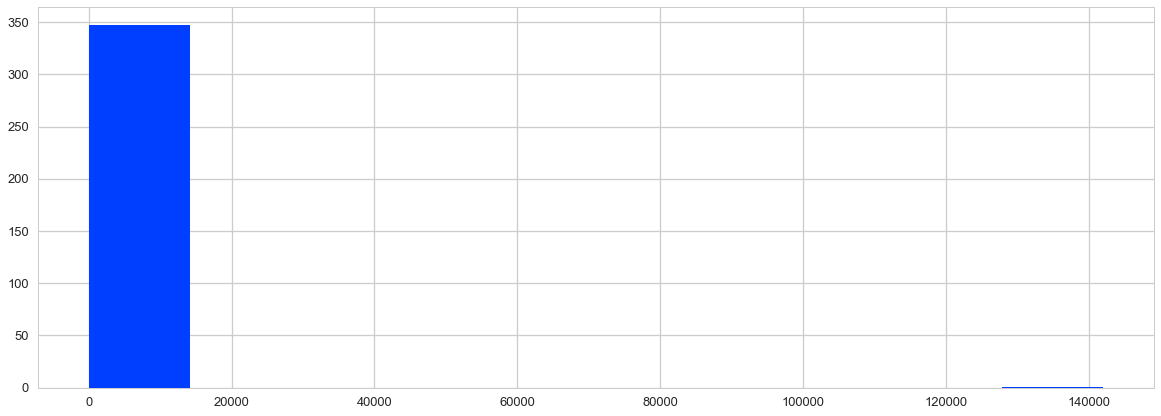

In [13]:
#begin eda by focusing on single varible - property crime - because this is the target
#histogram of Property Crime...not super helpful
plt.hist(df.Property_Crime);

In [14]:
#normalizing dataframe
def normalize(df):
    normalized_df = df.copy()
    for feature_name in df.columns:
        if df[feature_name].dtype == 'object':
            normalized_df[feature_name] = df[feature_name]
        else:
            max_value = df[feature_name].max()
            min_value = df[feature_name].min()
            normalized_df[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return normalized_df

In [15]:
#I know I don't want to normalize Robbery and Murder since we will change these to categorical
normal_df = df.drop(columns = ['City', 'Robbery', 'Murder']).copy()


normal_df = normalize(normal_df)
normal_df.head()

,Population,Violent_Crime,Rape_Legacy,Agg_Assault,Property_Crime,Burglary,Larceny,Motor_Vehicle_Theft
0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
3,0.012,0.015,0.027,0.017,0.029,0.042,0.027,0.019
4,0.001,0.000,0.003,0.001,0.002,0.003,0.001,0.001


In [16]:
#also normalizing test_df
test_normal_df = test_df.drop(columns = ['City', 'Robbery', 'Murder']).copy()
test_normal_df = normalize(test_normal_df)
test_normal_df.head()

,Population,Violent_Crime,Rape_Revised,Agg_Assault,Property_Crime,Burglary,Larceny,Motor_Vehicle_Theft
0,0.001,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1,0.036,0.004,0.004,0.004,0.021,0.016,0.026,0.004
2,0.001,0.000,0.000,0.000,0.000,0.000,0.000,0.001
3,0.008,0.000,0.000,0.001,0.001,0.001,0.001,0.000
4,0.004,0.000,0.000,0.000,0.000,0.001,0.000,0.000


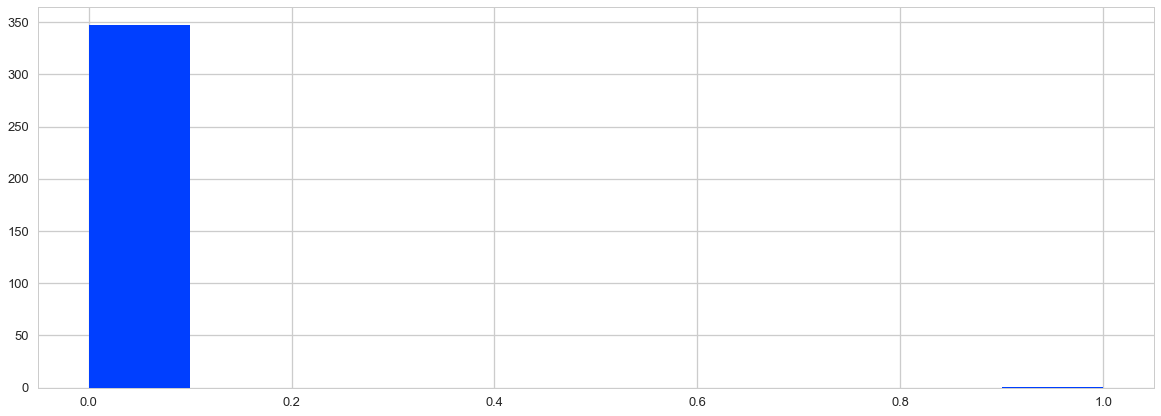

In [17]:
#trying histogram again...still looks the same..
plt.hist(normal_df.Property_Crime);

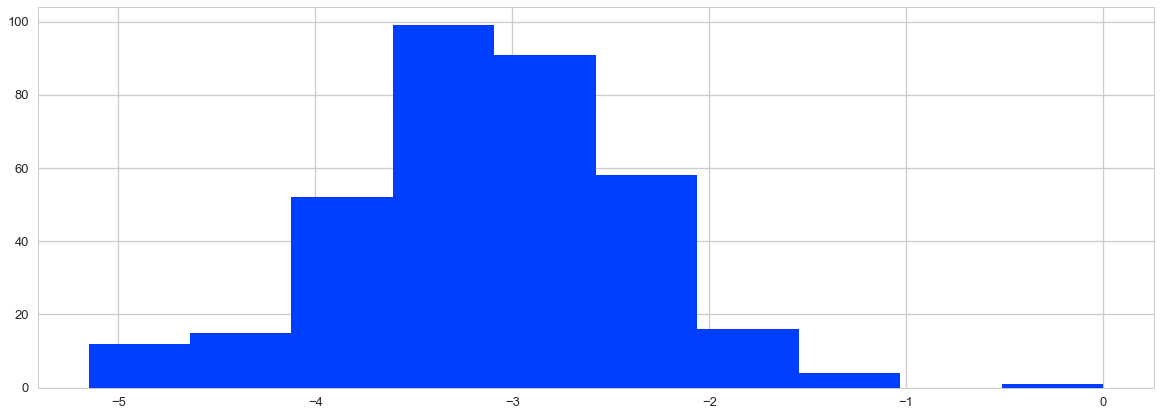

In [18]:
#since skewed to the left trying a log transformation

#apparently there are zero's in the column so replacing them with a really small number
normal_df = normal_df.replace(0, 0.00001)
test_normal_df = test_normal_df.replace(0, 0.00001)


log_property_crime = np.log10(normal_df.Property_Crime)
plt.hist(log_property_crime);
#yay that looks much better!

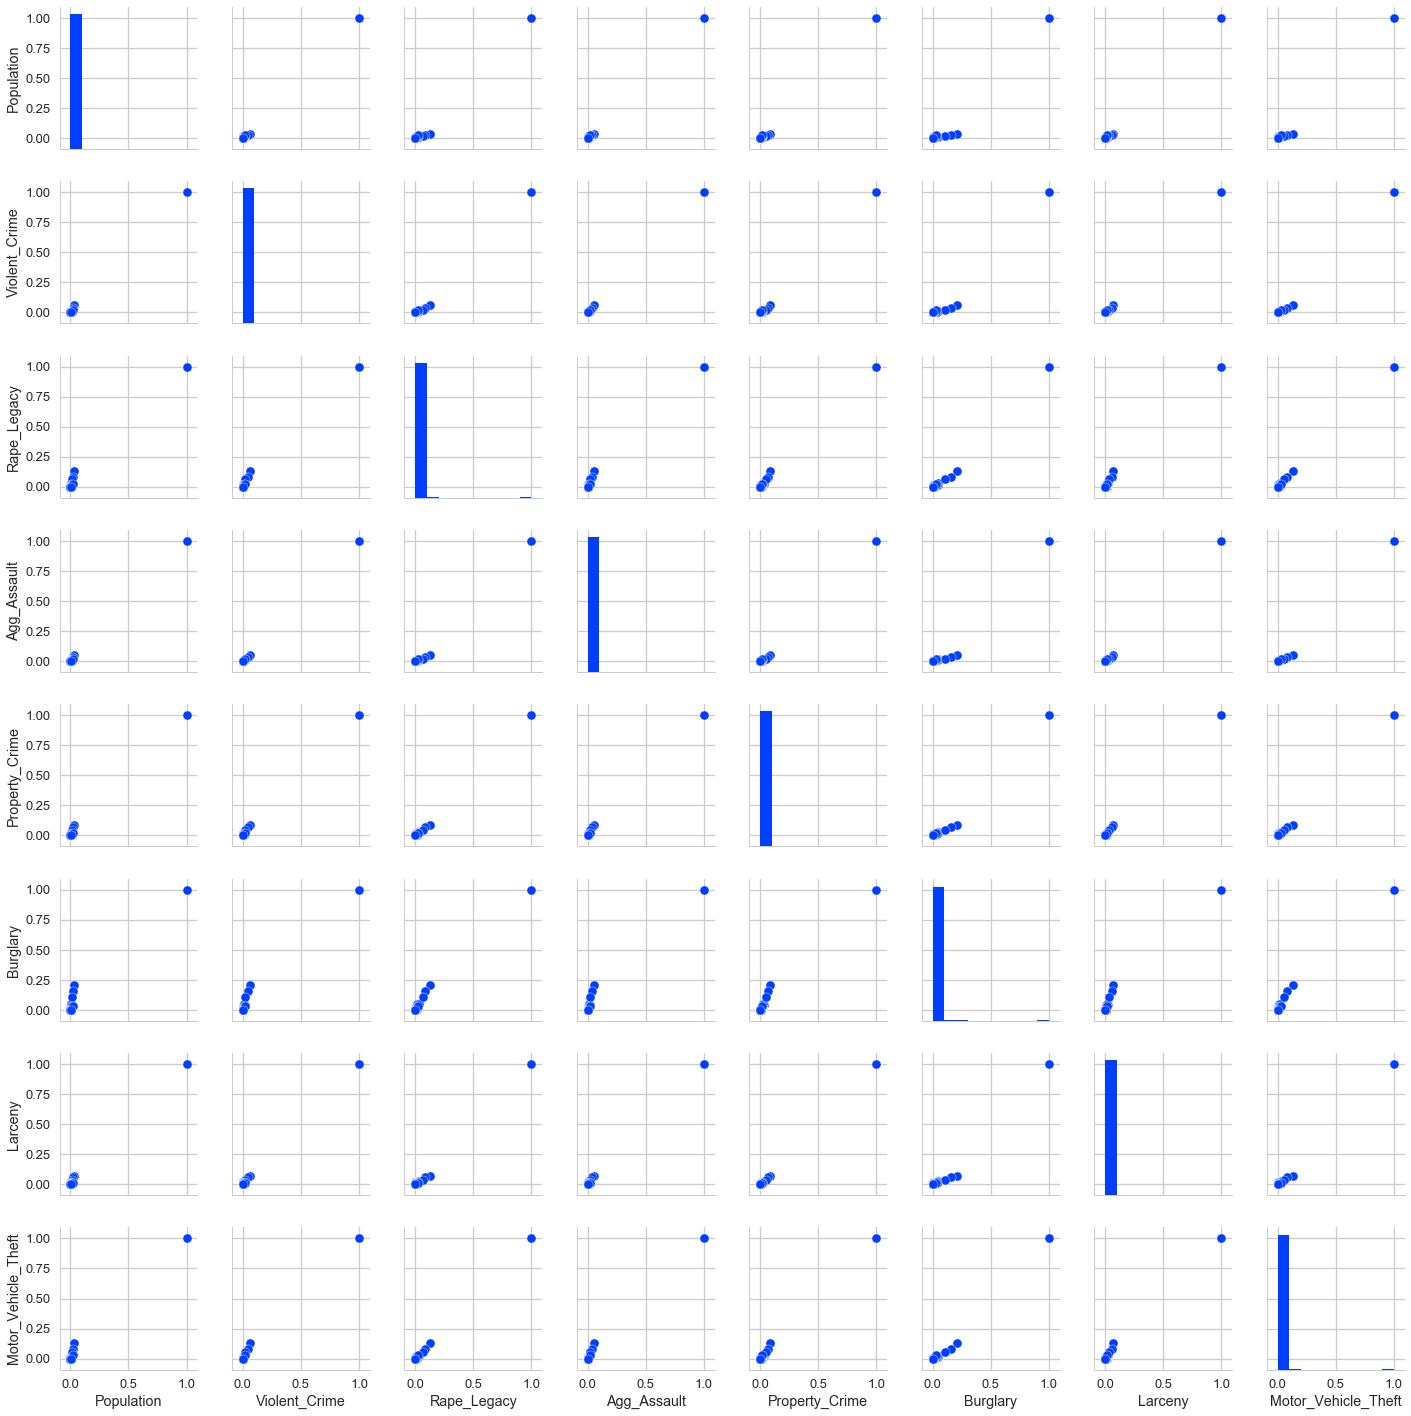

In [19]:
#now lets look at the rest of the dataframe too
normal_df = normal_df.dropna()
test_normal_df = test_normal_df.dropna()

sns.pairplot(normal_df);

In [20]:
normal_df.sample(5)

,Population,Violent_Crime,Rape_Legacy,Agg_Assault,Property_Crime,Burglary,Larceny,Motor_Vehicle_Theft
93,0.003,0.002,0.002,0.002,0.007,0.013,0.007,0.002
20,0.002,0.000,0.000,0.000,0.001,0.002,0.001,0.000
170,0.002,0.000,0.000,0.000,0.001,0.002,0.001,0.001
161,0.003,0.001,0.004,0.001,0.005,0.007,0.005,0.001
54,0.001,0.000,0.000,0.000,0.000,0.001,0.000,0.000


In [21]:
#it looks like all data is skewed to the right so trying log on everything
def logging(df):   
    log_df = df.copy()
    log_df = log_df.replace(0, 0.00001)
    for feature_name in df.columns:
        if df[feature_name].dtype == 'object':
            log_df[feature_name] = df[feature_name]
        else:
            log_df[feature_name] = np.log10(df[feature_name])     
    return log_df

In [22]:
log_df = logging(normal_df)
test_log_df = logging(test_normal_df)

In [23]:
log_df.sample(5)

,Population,Violent_Crime,Rape_Legacy,Agg_Assault,Property_Crime,Burglary,Larceny,Motor_Vehicle_Theft
284,-2.693,-4.719,-5.000,-4.502,-2.887,-2.840,-2.887,-3.026
255,-3.106,-5.000,-5.000,-5.000,-3.810,-4.220,-3.749,-5.000
171,-3.349,-3.397,-2.745,-3.272,-2.838,-2.587,-2.868,-3.394
328,-3.028,-4.117,-5.000,-3.900,-3.381,-3.442,-3.356,-3.871
127,-2.278,-3.038,-2.347,-3.087,-2.390,-2.480,-2.372,-2.529


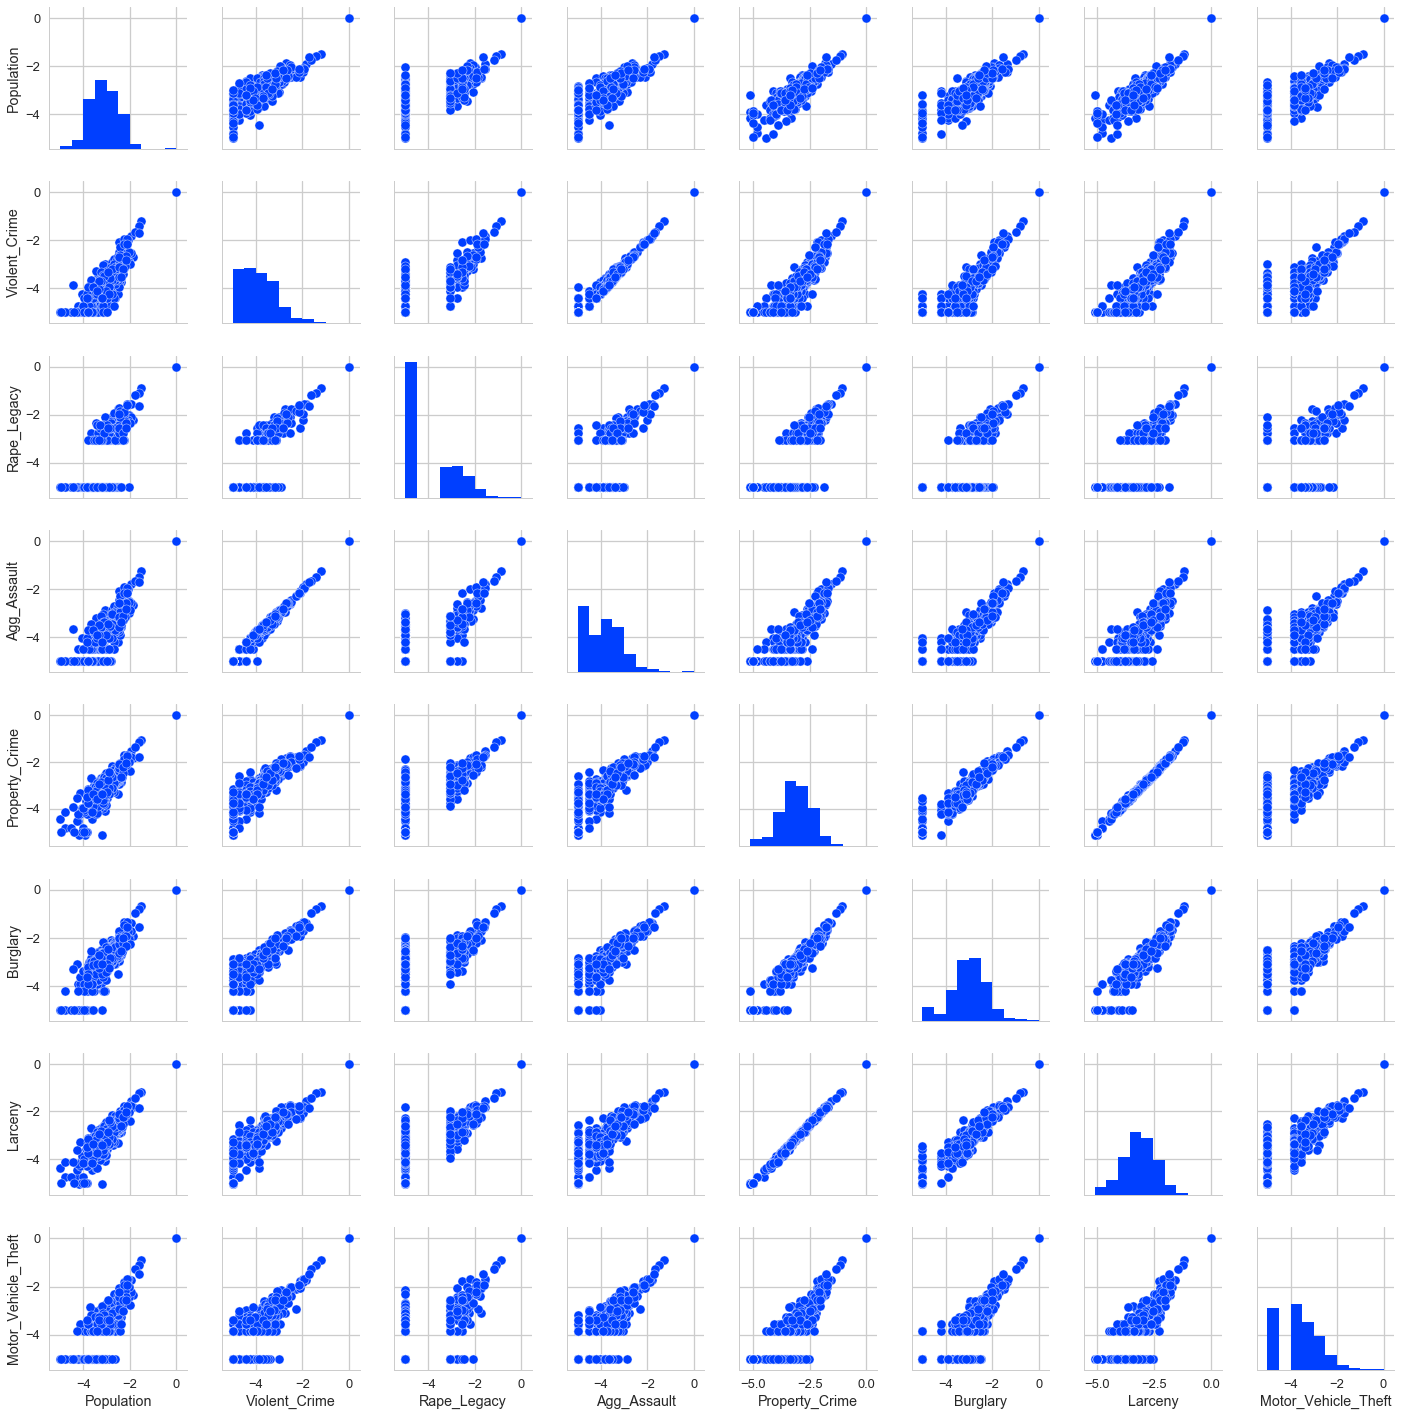

In [24]:
#log_df = plot_data.dropna()
sns.pairplot(log_df);

In [25]:
#adding Muder and Robbery back and converting to categorical
log_df['Murder'] = df.Murder
log_df['Murder'] = np.where(log_df.Murder >= 1, 1, 0)
log_df['Murder'] = log_df.Murder.astype('category')

log_df['Burglary'] = df.Burglary
log_df['Burglary'] = np.where(log_df.Burglary >= 1, 1, 0)
log_df['Burglary'] = log_df.Burglary.astype('category')

log_df.sample(5)

,Population,Violent_Crime,Rape_Legacy,Agg_Assault,Property_Crime,Burglary,Larceny,Motor_Vehicle_Theft,Murder
276,-2.467,-3.201,-2.444,-3.461,-2.234,1,-2.227,-2.570,1
11,-3.322,-4.020,-5.000,-4.201,-3.634,1,-3.624,-3.871,0
280,-3.584,-5.000,-5.000,-5.000,-3.897,1,-3.958,-3.871,0
94,-3.373,-4.418,-5.000,-4.502,-3.203,1,-3.180,-3.570,0
256,-4.050,-5.000,-5.000,-5.000,-5.000,0,-5.000,-5.000,0


In [26]:
#adding Muder and Robbery back and converting to categorical - same to test as to train
test_log_df['Murder'] = test_df.Murder
test_log_df['Murder'] = np.where(test_log_df.Murder >= 1, 1, 0)
test_log_df['Murder'] = test_log_df.Murder.astype('category')

test_log_df['Burglary'] = test_df.Burglary
test_log_df['Burglary'] = np.where(test_log_df.Burglary >= 1, 1, 0)
test_log_df['Burglary'] = test_log_df.Burglary.astype('category')

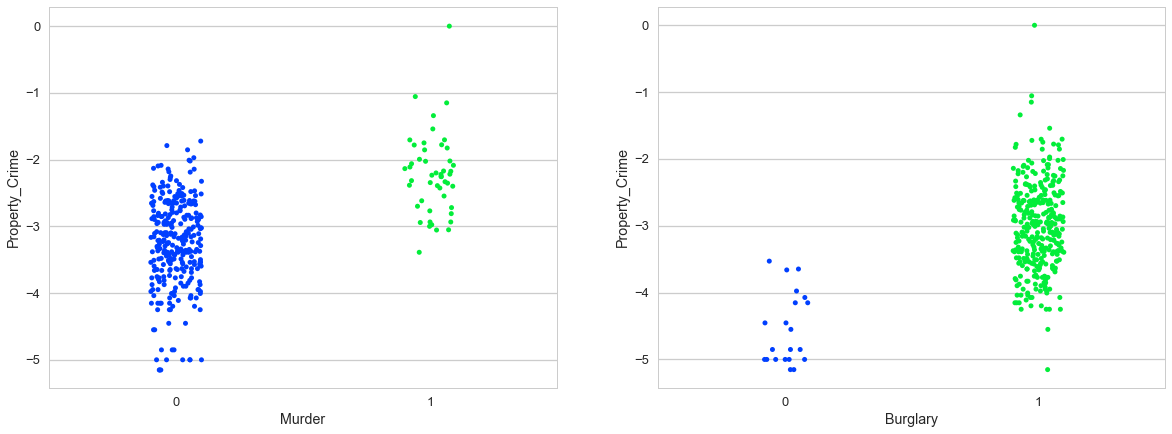

In [27]:
fig, ax = plt.subplots()

plt.subplot(121)
sns.stripplot(x="Murder", y="Property_Crime", data=log_df, jitter=True)

plt.subplot(122)
sns.stripplot(x='Burglary', y='Property_Crime', data=log_df, jitter=True)
plt.show;

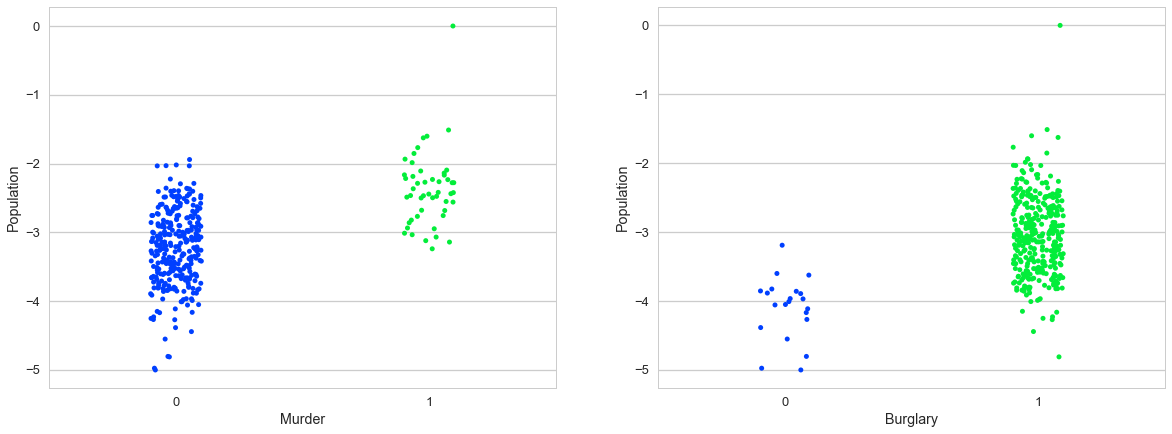

In [28]:
fig, ax = plt.subplots()

plt.subplot(121)
sns.stripplot(x="Murder", y="Population", data=log_df, jitter=True)

plt.subplot(122)
sns.stripplot(x='Burglary', y='Population', data=log_df, jitter=True)
plt.show;

In [29]:
log_df['Population2'] = df.Population ** 2
test_log_df['Population2'] = test_df.Population ** 2

## Model - Take One

In [30]:
### model 1 - running on original dataframe - training data

df['Population2'] = df.Population ** 2

# Instantiate and fit our model.
regr = linear_model.LinearRegression()
Y = df['Property_Crime']
X = df[['Population','Population2','Murder', 'Burglary']]
regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [ 9.75372708e-03  1.97831014e-10 -3.16038247e+01  3.41537561e+00]

Intercept: 
 2.549756990306946

R-squared:
0.9995953353177481


/usr/local/lib/python3.6/site-packages/sklearn/linear_model/base.py:509: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


### R-squared value is really high - probably overfitting

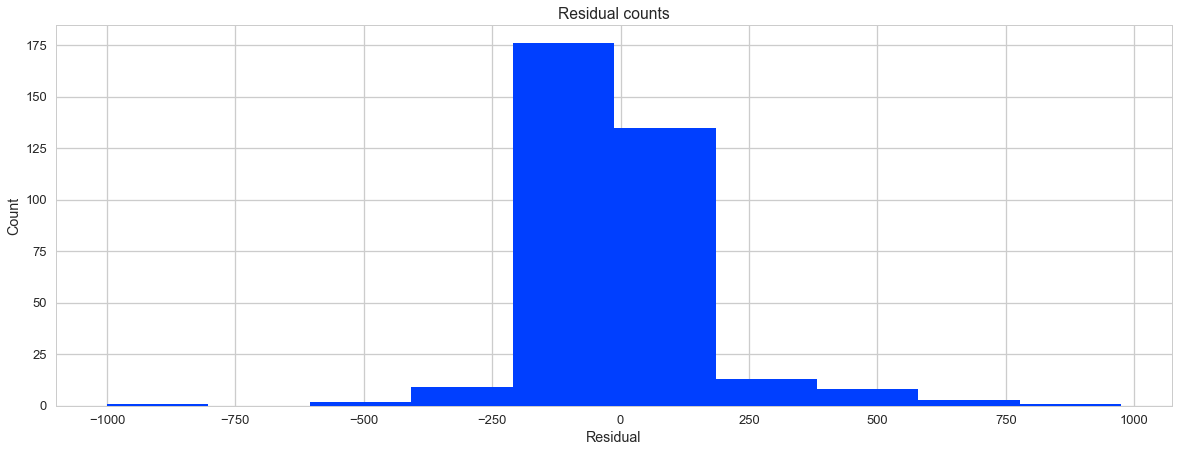

(0.7372438907623291, 4.308577772942052e-23)

In [31]:
# Extract predicted values.
predicted = regr.predict(X).ravel()
actual = df['Property_Crime']

# Calculate the error, also called the residual.
residual = actual - predicted

# This looks a bit concerning.
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

stats.shapiro(residual)

/usr/local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/usr/local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


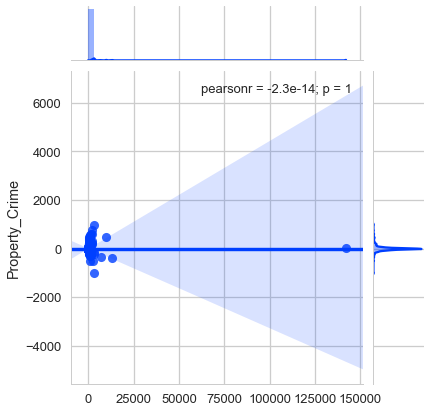

In [32]:
sns.jointplot(predicted, residual, kind='reg')

plt.show()

# looks like one outlier is way out there..

## Test Model - Take One

In [33]:
test_df['Population2'] = test_df.Population ** 2

# Instantiate and fit our model.
regr = linear_model.LinearRegression()
Y = test_df['Property_Crime']
X = test_df[['Population','Population2','Murder', 'Burglary']]
regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [1.36132411e-02 3.02188932e-09 1.37288521e+01 2.08065143e+00]

Intercept: 
 -13.49961131538413

R-squared:
0.9966476302039521


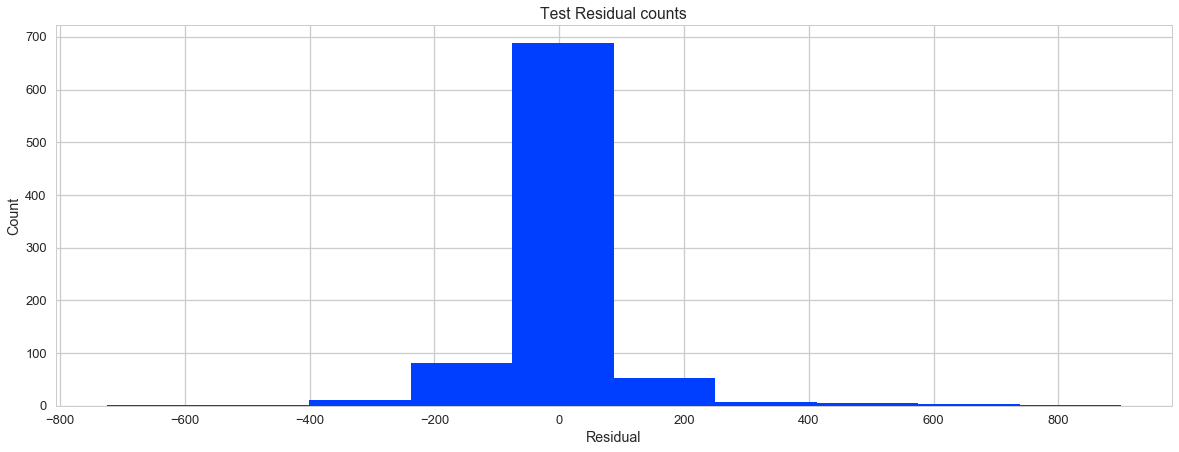

(0.7238878607749939, 2.815778766179412e-35)

In [34]:
# Extract predicted values.
predicted = regr.predict(X).ravel()
actual = test_df['Property_Crime']

# Calculate the error, also called the residual.
residual = actual - predicted

# This looks a bit concerning.
plt.hist(residual)
plt.title('Test Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

stats.shapiro(residual)

/usr/local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/usr/local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


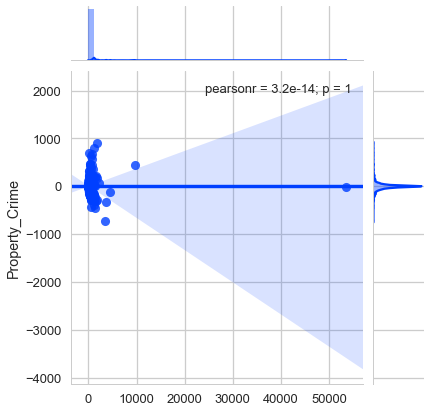

In [35]:
sns.jointplot(predicted, residual, kind='reg')

plt.show()

# looks like one outlier is way out there..

## Training Model - Take Two

In [36]:
### model 2 - get rid of outlier - NYC
df.loc[df.Property_Crime >= 100000]

,City,Population,Violent_Crime,Murder,Rape_Legacy,Robbery,Agg_Assault,Property_Crime,Burglary,Larceny,Motor_Vehicle_Theft,Population2
216,New York,8396126,52384,335,1112,19170,31767,141971,16606,117931,7434,70494931807876


In [37]:
df2 = df[df.City != 'New York']
test_df2 = test_df[test_df.City != 'New York']

In [38]:
# Instantiate and fit our model.
regr = linear_model.LinearRegression()
Y = df2['Property_Crime']
X = df2[['Population','Population2','Murder', 'Burglary']]
regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [ 1.25861854e-02 -2.92646759e-08 -1.10975212e+01  3.40661982e+00]

Intercept: 
 -25.38092508136657

R-squared:
0.9799496461099758


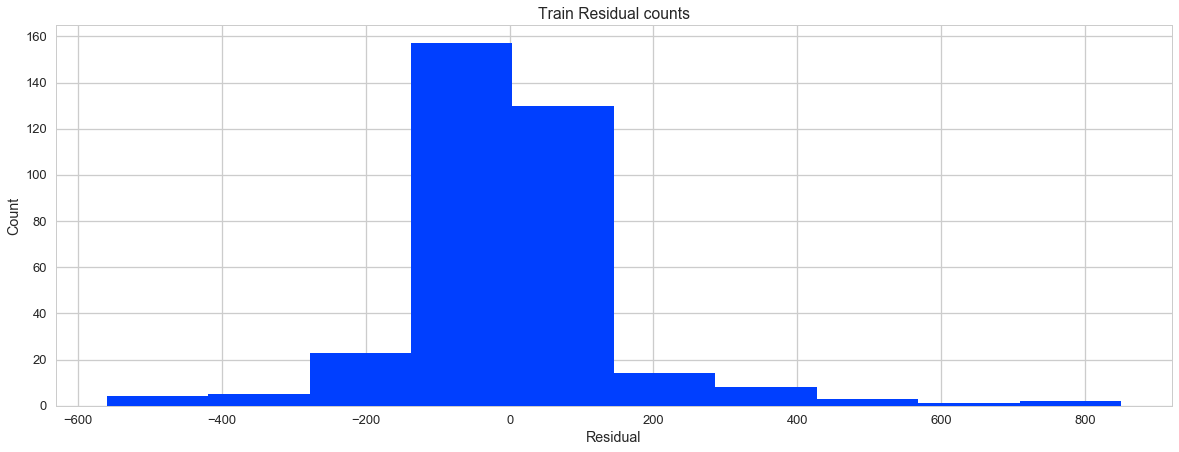

(0.8143570423126221, 1.1448694080677334e-19)

In [39]:
# Extract predicted values.
predicted = regr.predict(X).ravel()
actual = df2['Property_Crime']

# Calculate the error, also called the residual.
residual = actual - predicted

# This looks a bit concerning.
plt.hist(residual)
plt.title('Train Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

stats.shapiro(residual)

/usr/local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/usr/local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


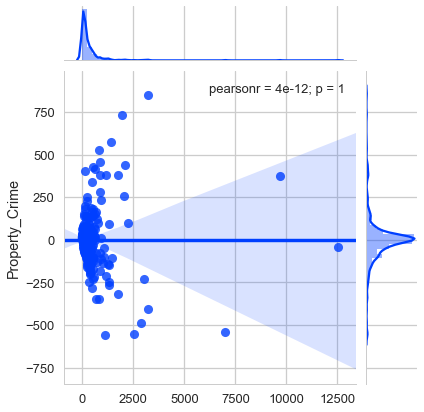

In [40]:
sns.jointplot(predicted, residual, kind='reg')
#plt.xlabel('Predicted')
#plt.ylabel('Residual')
#plt.axhline()
#plt.title('Residual vs. Predicted')
plt.show()

## Testing Model - Take Two

In [41]:
# Instantiate and fit our model.
regr = linear_model.LinearRegression()
Y = test_df2['Property_Crime']
X = test_df2[['Population','Population2','Murder', 'Burglary']]
regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [1.36132411e-02 3.02188932e-09 1.37288521e+01 2.08065143e+00]

Intercept: 
 -13.49961131538413

R-squared:
0.9966476302039521


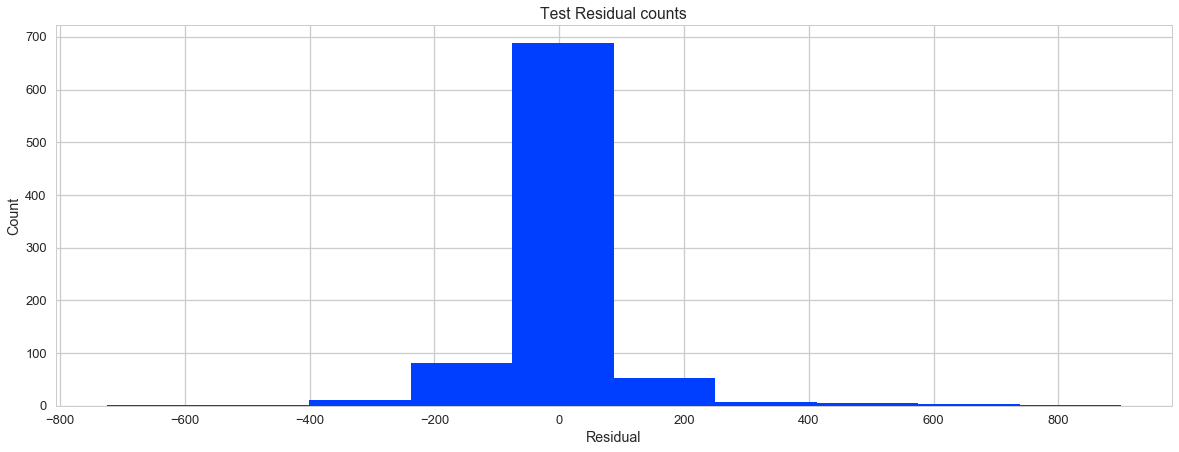

(0.7238878607749939, 2.815778766179412e-35)

In [42]:
# Extract predicted values.
predicted = regr.predict(X).ravel()
actual = test_df2['Property_Crime']

# Calculate the error, also called the residual.
residual = actual - predicted

# This looks a bit concerning.
plt.hist(residual)
plt.title('Test Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

stats.shapiro(residual)

/usr/local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/usr/local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


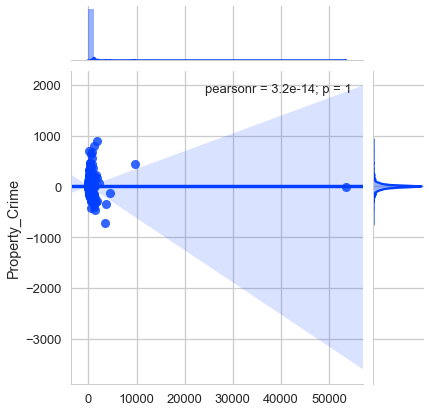

In [43]:
sns.jointplot(predicted, residual, kind='reg')
plt.show()

## Training Model - Take Three

In [44]:
# Instantiate and fit our model.
regr = linear_model.LinearRegression()
Y = log_df['Property_Crime']
X = log_df[['Population','Population2','Murder', 'Burglary']]
regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [9.02526521e-01 1.19910649e-15 2.21200543e-01 5.45174838e-01]

Intercept: 
 -0.8501775980131825

R-squared:
0.7851903672458008


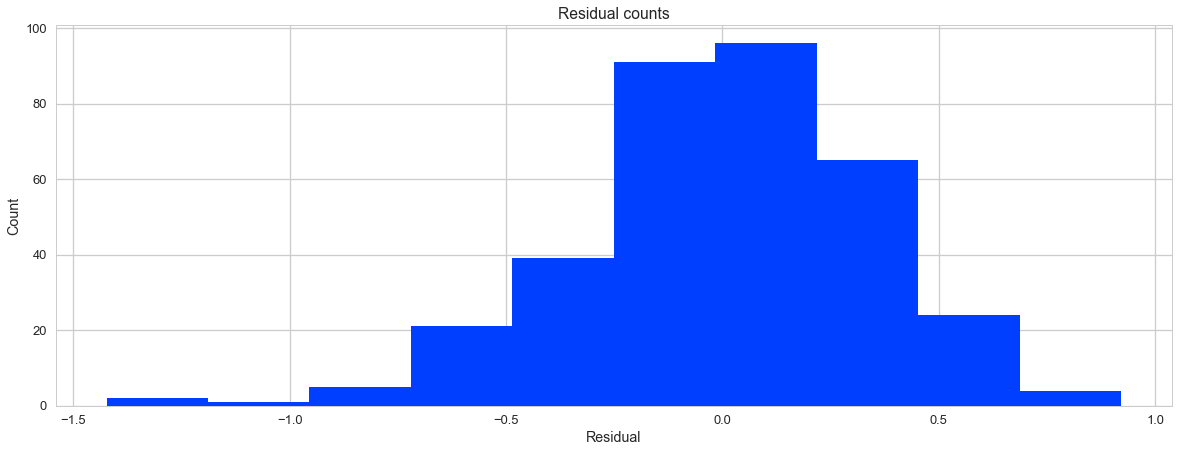

(0.9834667444229126, 0.0005036470829509199)

In [45]:
# Extract predicted values.
predicted = regr.predict(X).ravel()
actual = log_df['Property_Crime']

# Calculate the error, also called the residual.
residual = actual - predicted

# This looks a bit concerning.
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

stats.shapiro(residual)

/usr/local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/usr/local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


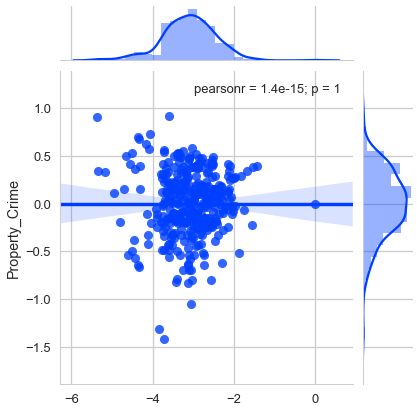

In [46]:
sns.jointplot(predicted, residual, kind='reg')
plt.show();

## Testing Model - Take Three

In [47]:
##### test data #####


# Instantiate and fit our model.
regr = linear_model.LinearRegression()
Y = test_log_df['Property_Crime']
X = test_log_df[['Population','Population2','Murder', 'Burglary']]
regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [9.52613196e-01 1.17393572e-13 2.50149863e-01 7.69688283e-01]

Intercept: 
 -1.2888013891480883

R-squared:
0.7751406328347905


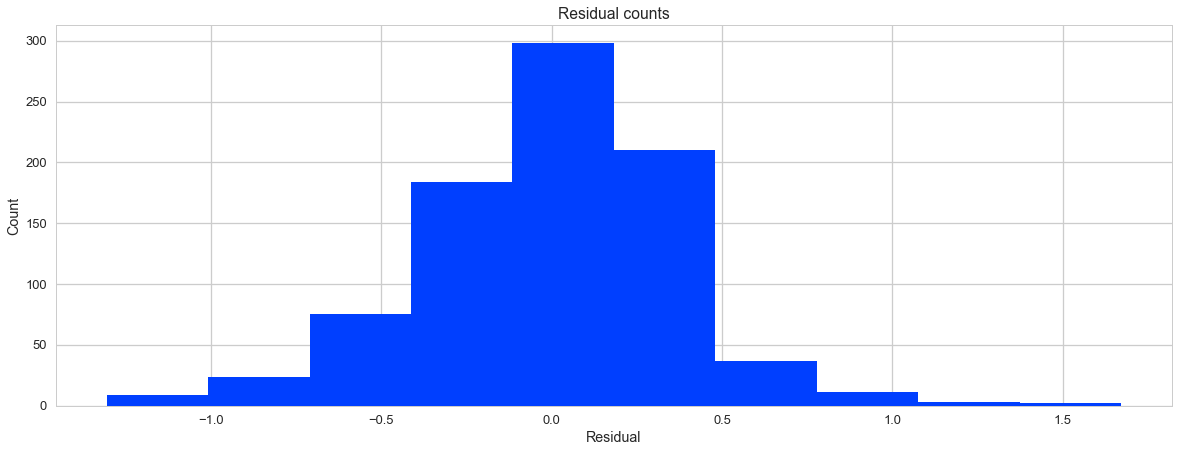

(0.9823024868965149, 1.20829684036039e-08)

In [48]:
# Extract predicted values.
predicted = regr.predict(X).ravel()
actual = test_log_df['Property_Crime']

# Calculate the error, also called the residual.
residual = actual - predicted

# This looks a bit concerning.
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

stats.shapiro(residual)

/usr/local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/usr/local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


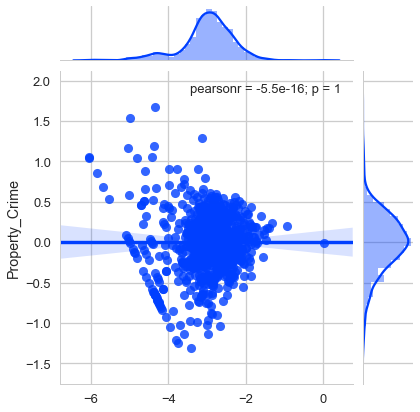

In [49]:
sns.jointplot(predicted, residual, kind='reg')
plt.show();